# Monthly Sunspot

This dataset describes a monthly count of the number of observed sunspots for just over 230 years (1749-1983).

The units are a count and there are 2,820 observations. The source of the dataset is credited to Andrews & Herzberg (1985).

## Exploratory Analysis

Before we do any machine learning we should visualise the data

In [43]:
import pandas as pd
import os
import plotly
import plotly.express as px
import plotly.io as pio

import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import torch.optim as optim

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np
from sklearn.ensemble import RandomForestRegressor

import warnings

# Suppress specific warnings if necessary
warnings.filterwarnings('ignore', category=FutureWarning, message="is_sparse is deprecated and will be removed in a future version.")


df = pd.read_csv("./data/uv-data.csv")

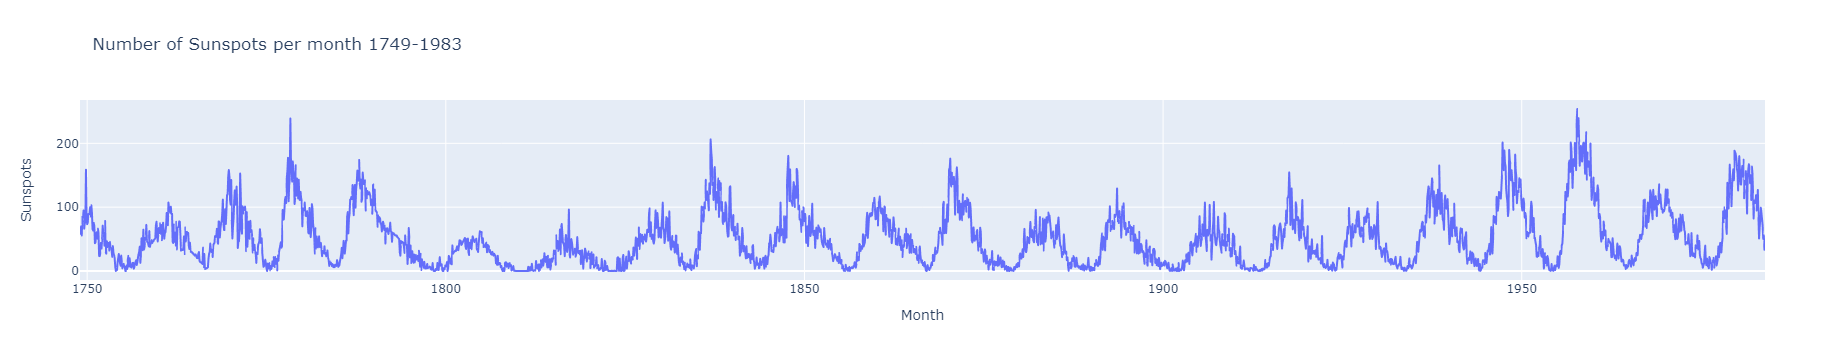

In [30]:
# Assuming your DataFrame is named 'df'
fig = px.line(df, x='Month', y='Sunspots',title='Number of Sunspots per month 1749-1983')
# Show the interactive plot

fig.show()

In [31]:
# Convert the 'Month' column to datetime format
df['Month'] = pd.to_datetime(df['Month'])

# Set 'Month' as the index of the DataFrame for time series analysis
df.set_index('Month', inplace=True)

# Checking the processed DataFrame
df.head()


,Sunspots
Month,
1749-01-01,58.0
1749-02-01,62.6
1749-03-01,70.0
1749-04-01,55.7
1749-05-01,85.0


Few obervations about the data:

- There is a seasonality to this, the sin wave appears to have a frequency of ~10 years
- The sun spot peaks appear random, maybe slight oscilating behaviour
- Wave peaks appear to have a left skew

## Machine Learning

Given the seasonality and the univariate nature of the data there are few algortihmns I would like to try:

- ARIMA
- Linear Regression
- Random Forest
- LSTM Neural Network
- RNN

First we need to prepare the data using train_test_split.

## Autoregressive integrated moving average - ARIMA

ADF Statistic: -9.567667511913092
p-value: 2.3334521438661037e-16


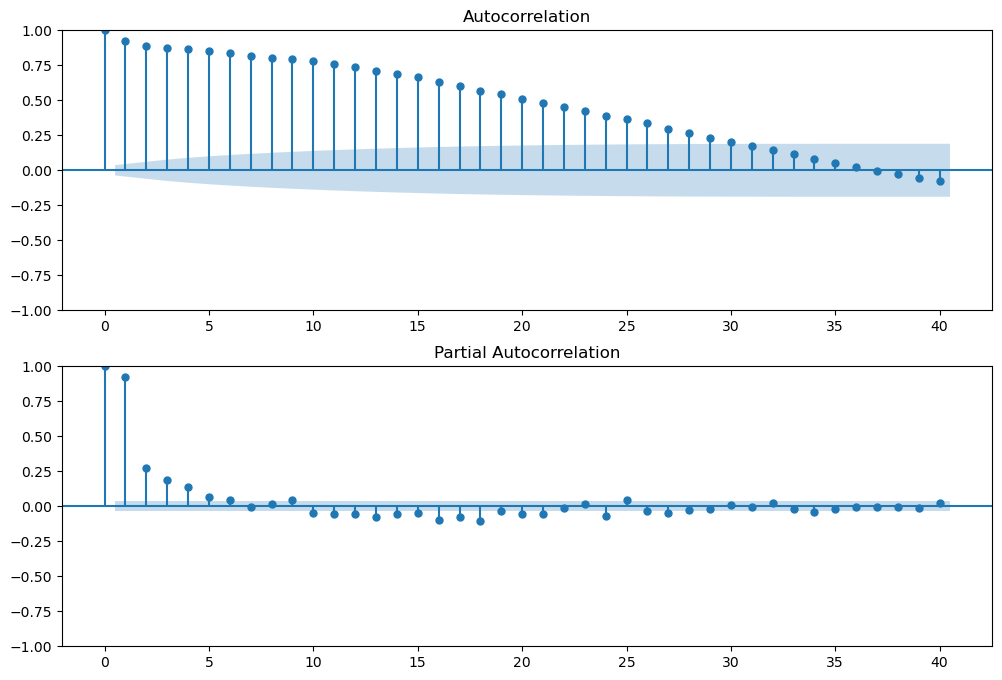

In [32]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from pandas.plotting import autocorrelation_plot
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Check stationarity
result = adfuller(df['Sunspots'])
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")

# Display ACF and PACF plots to help determine the ARIMA parameters
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))
plot_acf(df['Sunspots'], ax=ax1, lags=40)
plot_pacf(df['Sunspots'], ax=ax2, lags=40)
plt.show()


In [33]:
# Fit ARIMA model with initial parameters p=1, d=0, q=0
model_arima = ARIMA(df['Sunspots'], order=(1, 0, 0))
model_arima_fit = model_arima.fit()

# Print out the summary of the ARIMA model
model_arima_fit.summary()


C:\Users\jtren\anaconda3\envs\time-series\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

C:\Users\jtren\anaconda3\envs\time-series\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

C:\Users\jtren\anaconda3\envs\time-series\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:               Sunspots   No. Observations:                 2820
Model:                 ARIMA(1, 0, 0)   Log Likelihood              -11966.887
Date:                Tue, 28 May 2024   AIC                          23939.774
Time:                        17:25:23   BIC                          23957.608
Sample:                    01-01-1749   HQIC                         23946.209
                         - 12-01-1983                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         51.2659      5.124     10.004      0.000      41.222      61.309
ar.L1          0.9214      0.007    134.360      0.000       0.908       0.935
sigma2       283.9413      4.811     59.014      0.000     274.511     293.371
===================================================================================
Ljung-Box (L1) (Q):                 177.36   Jarque-Bera (JB):              1575.97
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.30   Skew:                             0.67
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.41
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## Linear Regression

Test MSE: 349.69978489506644
Test R2 Score: 0.8933222691843092


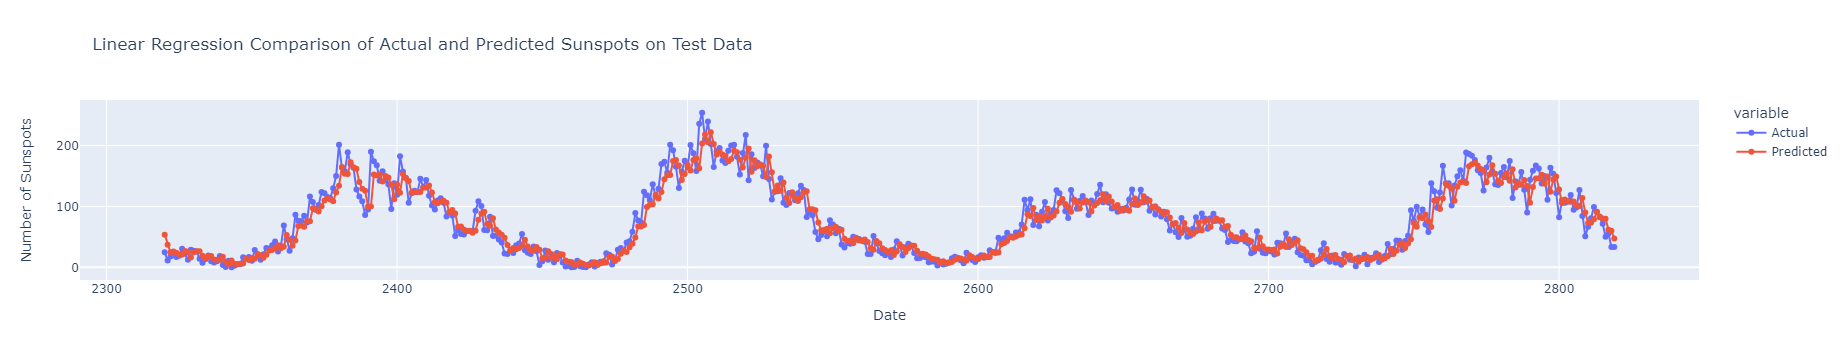

In [44]:
# Creating a function to create lagged features
def create_lagged_features(df, n_lags):
    for i in range(1, n_lags + 1):
        df[f'lag_{i}'] = df['Sunspots'].shift(i)
    df.dropna(inplace=True)
    return df

# Assuming df is your DataFrame containing the Sunspots data and a date column 'Date'
df['Date'] = pd.to_datetime(df['Month'])  # Ensure 'Date' is in datetime format

# Create lagged features for the dataset
data_lagged = create_lagged_features(df[['Sunspots']].copy(), 10)

# Prepare features and target variables
X = data_lagged.drop('Sunspots', axis=1)
y = data_lagged['Sunspots']

# Manual train-test split to ensure the last 500 points are in the test set
split_index = len(X) - 500
X_train, X_test = X.iloc[:split_index], X.iloc[split_index:]
y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]

# Ensure the features are numeric
X_train = X_train.apply(pd.to_numeric)
X_test = X_test.apply(pd.to_numeric)

# Create and fit Linear Regression model
model_lr = LinearRegression()
model_lr.fit(X_train, y_train)

# Predict and evaluate the model
y_pred = model_lr.predict(X_test)
mse_lr = mean_squared_error(y_test, y_pred)
r2_lr = r2_score(y_test, y_pred)

print(f"Test MSE: {mse_lr}")
print(f"Test R2 Score: {r2_lr}")

# Combine actual and predicted values into a DataFrame for plotting
results_df = pd.DataFrame({'Actual': y_test.values, 'Predicted': y_pred}, index=y_test.index)

# Plotting the results using Plotly Express
fig = px.line(results_df, y=['Actual', 'Predicted'], markers=True,
              labels={'value': 'Number of Sunspots', 'index': 'Date'},
              title='Linear Regression Comparison of Actual and Predicted Sunspots on Test Data')
fig.update_traces(mode='markers+lines')
fig.show()

## Random Forest Regressor

In [45]:
from sklearn.ensemble import RandomForestRegressor

# Create and fit Random Forest model
model_rf = RandomForestRegressor(n_estimators=100, random_state=42)
model_rf.fit(X_train, y_train)

# Predict and evaluate the model
y_pred_rf = model_rf.predict(X_test)
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = model_rf.score(X_test, y_test)


Mean Squared Error: 437.4510970700001
R2 Score: 0.8665532768564181


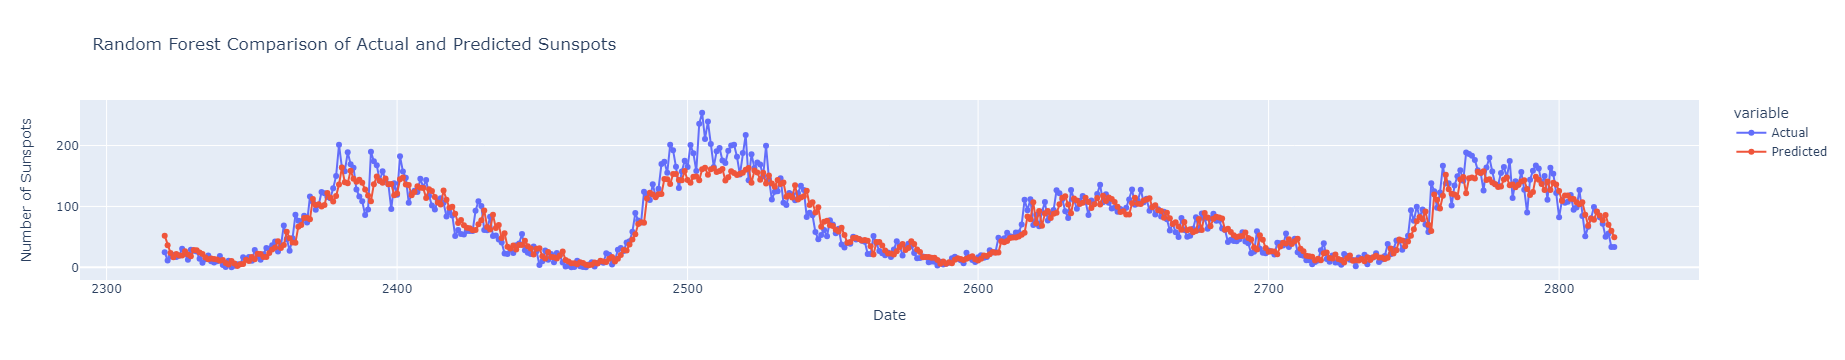

In [47]:
# Output MSE and R2 scores
print(f"Mean Squared Error: {mse_rf}")
print(f"R2 Score: {r2_rf}")

# Combine actual and predicted values into a DataFrame for plotting
results_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred_rf}, index=y_test.index)

# Sort results by index (Date)
results_df.sort_index(inplace=True)

# Plotting the results using Plotly Express
fig = px.line(results_df, y=['Actual', 'Predicted'], markers=True,
              labels={'value': 'Number of Sunspots', 'index': 'Date'},
              title='Random Forest Comparison of Actual and Predicted Sunspots')
fig.update_traces(mode='markers+lines')
fig.show()


## LSTM

In [58]:
# Function to prepare the dataset
def create_dataset(df, time_steps=1):
    X, y = [], []
    for i in range(len(df) - time_steps):
        X.append(df.iloc[i:(i + time_steps)].values)
        y.append(df.iloc[i + time_steps].values)
    return np.array(X), np.array(y)

# Scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df['Sunspots'].values.reshape(-1, 1))

# Create dataset with a look-back period
time_steps = 10
X, y = create_dataset(pd.DataFrame(scaled_data), time_steps)

# Manual train-test split to ensure the last 500 points are in the test set
split_index = len(X) - 500
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

# Convert to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).reshape(-1, 1)
y_test = torch.tensor(y_test, dtype=torch.float32).reshape(-1, 1)

# DataLoader setup
train_data = TensorDataset(X_train, y_train)
test_data = TensorDataset(X_test, y_test)
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

# Define a simpler LSTM model
class SimpleLSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers, dropout_prob):
        super(LSTMModelWithDropout, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout_prob)
        self.dropout = nn.Dropout(dropout_prob)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        h0 = torch.zeros(self.lstm.num_layers, x.size(0), self.lstm.hidden_size).to(x.device)
        c0 = torch.zeros(self.lstm.num_layers, x.size(0), self.lstm.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.dropout(out)
        out = self.fc(out[:, -1, :])
        return out

# Initialize the model, loss function, and optimizer
model = SimpleLSTMModel(input_size=1, hidden_size=50, output_size=1, num_layers=2, dropout_prob=0.2)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
def train_model(model, train_loader, criterion, optimizer, num_epochs=50):
    model.train()
    for epoch in range(num_epochs):
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)
            loss.backward()
            optimizer.step()
        print(f'Epoch {epoch+1}, Loss: {loss.item()}')

train_model(model, train_loader, criterion, optimizer)

# Evaluation function
def evaluate_model(model, test_loader):
    model.eval()
    predictions, actuals = [], []
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            y_pred = model(X_batch)
            predictions.append(y_pred.numpy())
            actuals.append(y_batch.numpy())
    predictions = np.concatenate(predictions).ravel()  # Flattening the array
    actuals = np.concatenate(actuals).ravel()  # Flattening the array
    mse = mean_squared_error(actuals, predictions)
    r2 = r2_score(actuals, predictions)
    print(f'Test MSE: {mse}')
    print(f'Test R2 Score: {r2}')
    return predictions, actuals

# Evaluate the model and get predictions and actuals for the test set
predictions, actuals = evaluate_model(model, test_loader)

# Rescale predictions back to original scale
predictions_rescaled = scaler.inverse_transform(predictions.reshape(-1, 1)).flatten()
actuals_rescaled = scaler.inverse_transform(actuals.reshape(-1, 1)).flatten()

# Combine actual and predicted values into a DataFrame for plotting
results_df = pd.DataFrame({'Actual': actuals_rescaled, 'Predicted': predictions_rescaled})

# Plotting the results using Plotly Express
fig = px.line(results_df, y=['Actual', 'Predicted'], markers=True,
              labels={'value': 'Number of Sunspots', 'index': 'Index'},
              title='LSTM Comparison of Actual and Predicted Sunspots on Test Data')
fig.update_traces(mode='markers+lines')
fig.show()

# Calculate evaluation metrics
mse = mean_squared_error(actuals_rescaled, predictions_rescaled)
r2 = r2_score(actuals_rescaled, predictions_rescaled)
print(f'Test MSE: {mse}')
print(f'Test R2 Score: {r2}')

TypeError: super(type, obj): obj must be an instance or subtype of type